In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [89]:
#force output to display the full description
pd.set_option('display.max_colwidth', 20)

In [ ]:
wine_data = pd.read_csv("../data/raw/wine-reviews/winemag-data-130k-v2.csv", index_col=0)

In [95]:
#create connection to database
conn = sqlite3.connect('db\wine_data.sqlite')
c = conn.cursor()

In [62]:
wine_data['country'] = wine_data['country'].fillna("Unknown")
wine_data['designation'] = wine_data['designation'].fillna("Unknown")
wine_data['province'] = wine_data['province'].fillna("Unknown")
wine_data['region_1'] = wine_data['region_1'].fillna("Unknown")
wine_data['region_2'] = wine_data['region_2'].fillna("Unknown")
wine_data['taster_name'] = wine_data['taster_name'].fillna("Unknown")
wine_data['taster_twitter_handle'] = wine_data['taster_twitter_handle'].fillna("Unknown")
wine_data['variety'] = wine_data['variety'].fillna("Unknown")
wine_data['price'] = wine_data['price'].fillna(0)

#Drop the duplicate descriptions
wine_data = wine.drop_duplicates('description') # 10016 duplicates

In [ ]:
wine_data.to_sql('wine_data', conn, if_exists = "replace")

In [67]:
wine_data.shape

(119955, 13)

In [70]:
wine_data[wine_data['price']==0]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,0.0,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte
30,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,0.0,Beaujolais,Beaujolais-Villages,Unknown,Roger Voss,@vossroger,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone
31,Italy,Merlot and Nero d'Avola form the base for this...,Calanìca Nero d'Avola-Merlot,86,0.0,Sicily & Sardinia,Sicilia,Unknown,Unknown,Unknown,Duca di Salaparuta 2010 Calanìca Nero d'Avola-...,Red Blend,Duca di Salaparuta
32,Italy,"Part of the extended Calanìca series, this Gri...",Calanìca Grillo-Viognier,86,0.0,Sicily & Sardinia,Sicilia,Unknown,Unknown,Unknown,Duca di Salaparuta 2011 Calanìca Grillo-Viogni...,White Blend,Duca di Salaparuta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129844,Italy,"Doga delle Clavule is a neutral, mineral-drive...",Doga delle Clavule,86,0.0,Tuscany,Morellino di Scansano,Unknown,Unknown,Unknown,Caparzo 2006 Doga delle Clavule (Morellino di...,Sangiovese,Caparzo
129860,Portugal,This rich wine has a firm structure as well as...,Pacheca Superior,90,0.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta da Pacheca 2013 Pacheca Superior Red (D...,Portuguese Red,Quinta da Pacheca
129863,Portugal,This mature wine that has 50% Touriga Nacional...,Reserva,90,0.0,Dão,Unknown,Unknown,Roger Voss,@vossroger,Seacampo 2011 Reserva Red (Dão),Portuguese Red,Seacampo
129893,Italy,"Aromas of passion fruit, hay and a vegetal not...",Corte Menini,91,0.0,Veneto,Soave Classico,Unknown,Kerin O’Keefe,@kerinokeefe,Le Mandolare 2015 Corte Menini (Soave Classico),Garganega,Le Mandolare


In [72]:
wine_data.isna().sum() # no "taster_name", "taster_twitter_handle"

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

In [30]:
# wine.to_csv("../data/processed/winemag-data-130k-processed.csv")

In [38]:
wine150k = pd.read_csv("../data/raw/wine-reviews/winemag-data_first150k.csv", index_col=0)

In [74]:
wine_sample = wine_data.sample(n=10000, random_state=2020)

In [75]:
wine_sample.shape

(10000, 13)

In [76]:
wine_data.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [77]:
wine_data["country"].value_counts()

US                        50448
France                    20351
Italy                     17921
Spain                      6116
Portugal                   5256
Chile                      4184
Argentina                  3543
Austria                    3033
Australia                  2197
Germany                    1992
South Africa               1301
New Zealand                1278
Israel                      466
Greece                      431
Canada                      226
Bulgaria                    132
Hungary                     129
Romania                     102
Uruguay                      98
Turkey                       81
Slovenia                     77
Georgia                      76
Croatia                      70
Mexico                       68
England                      63
Unknown                      59
Moldova                      56
Brazil                       49
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine 

In [53]:
wine['designation'].value_counts()

Reserve                          2009
Estate                           1322
Reserva                          1259
Riserva                           698
Estate Grown                      621
                                 ... 
Luziafeld                           1
Blecua                              1
Proyecto Cu4tro Blanco              1
Abtsberg Spätlese Grosse Lage       1
Giancòla                            1
Name: designation, Length: 37979, dtype: int64

In [59]:
37465/wine_data_num

0.28825661109016626

In [60]:
2009/wine_data_num

0.015457294319502043

designation
* 28.8% is null
* 1.5 % is Reserve



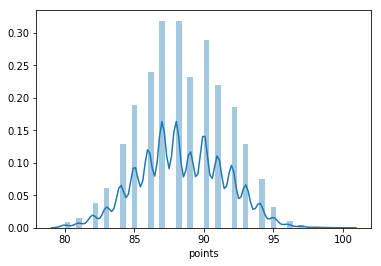

In [79]:
sns.distplot(wine_data['points'])

In [80]:
wine_data['points'].describe()

count    119955.000000
mean         88.442291
std           3.093029
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

* All points has value. 
* 80 - 100 

price
max:3300

In [103]:
wine_price_0_200 = wine_data[(wine['price']>0) & (wine['price']<200)]
wine_price_200_1000 = wine[(wine['price']>200) & (wine['price']<1000)]
wine_price_1000_2000 = wine[(wine['price']>1000) & (wine['price']<2000)]
wine_price_2000_3300 = wine[(wine['price']>2000) & (wine['price']<=3300)]

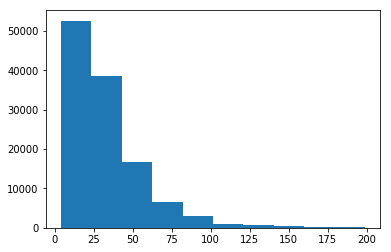

In [94]:
plt.hist(wine_price_0_200['price']);

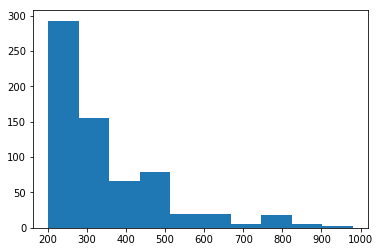

In [96]:
plt.hist(wine_price_200_1000['price']);

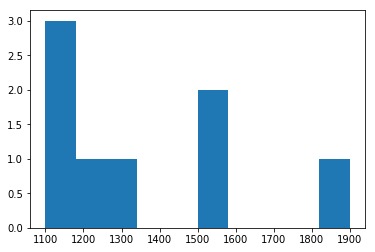

In [104]:
plt.hist(wine_price_1000_2000['price']);

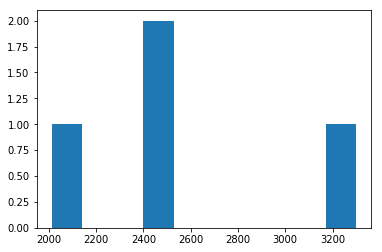

In [105]:
plt.hist(wine_price_2000_3300['price']);

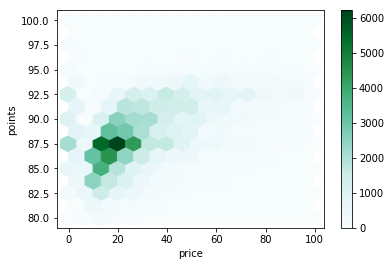

In [82]:
wine_data[wine_data['price'] < 100].plot.hexbin(x='price', y='points', gridsize=15)

Bag of Words
* Basic Cleaning and Tokenization
* Stemming, Lemmatization, and Stop Words
* Vectorization Strategies
* TF-IDF Vectorization

In [84]:
#dependencies

import sqlite3
from sqlite3 import Error
import re
from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#force output to display the full description
pd.set_option('display.max_colwidth', -1)

In [96]:
#create the pandas data frame
wine_df = pd.read_sql('Select title, description, points, price from wine_data', conn)

In [101]:
wine_df.head()

,title,description,points,price,word_count
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",87,0.0,24
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",87,15.0,39
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",87,14.0,28
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,33
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",87,65.0,41


In [99]:
#inline function to produce word count, splitting on spaces
wine_df['word_count'] = wine_df['description'].apply(lambda x: len(str(x).split(" ")))
wine_df.word_count.describe()

count    119955.000000
mean         40.424451
std          11.206029
min           3.000000
25%          33.000000
50%          40.000000
75%          47.000000
max         135.000000
Name: word_count, dtype: float64

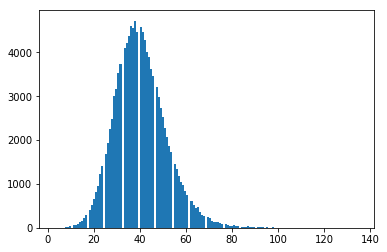

In [118]:
#set x for the histogram and set bins based on max
x = wine_df['word_count']
n_bins = 150
#plot histogram
plt.hist(x, bins=n_bins)
plt.show()

In [102]:
wine_df.head()

,title,description,points,price,word_count
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",87,0.0,24
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",87,15.0,39
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",87,14.0,28
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,33
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",87,65.0,41


In [110]:
wine_df[wine_df["word_count"]==135]

,title,description,points,price,word_count
26314,Meander 2006 Morisoli Vineyard Cabernet Sauvig...,This very fine Cabernet wants a little time in...,93,100.0,135


In [103]:
#creat a table in the database
wine_data.to_sql('wine_data', conn, if_exists = "replace")
#read the table in the database
wine_df = pd.read_sql('Select * from wine_data', conn)

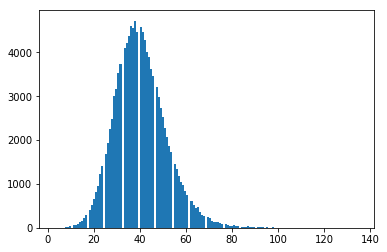

In [95]:
#create a column named color
wine_df["color"] = ""

In [98]:
pd.read_sql("""
SELECT variety, count(variety) as vcount 
FROM wine_data
GROUP BY variety
"""
, conn)

,variety,vcount
0,None,0
1,Abouriou,3
2,Agiorgitiko,63
3,Aglianico,359
4,Aidani,1
...,...,...
703,Zinfandel,2714
704,Zlahtina,2
705,Zweigelt,209
706,Çalkarası,2
